Import libraries

In [1]:
import json
from mysql.connector import errorcode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, inspect
from scipy.stats import shapiro, kstest, normaltest, probplot,zscore,f_oneway,kruskal,pearsonr,chi2_contingency
from datetime import datetime
import scipy.stats as stats

In [2]:
GREEN = "\033[32m"
RESET = "\033[0m"

# Question 1.

Create the SQLAlchemy engine

In [6]:
with open("../references/db_config.json", 'r') as configfile:
    db_config=json.load(configfile)

engine = create_engine(f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")

Load each table into a Dictionary

In [7]:
# Initialize the inspector to get table names
inspector = inspect(engine)
tables = inspector.get_table_names()

# Dictionary to hold the DataFrames
dataframes = {}
for table_name in tables:
    df = pd.read_sql(f"SELECT * FROM {table_name}", engine)
    dataframes[table_name] = df

Load tables into a separate DataFrame

In [8]:
album = dataframes['album']
artist = dataframes['artist']
customer = dataframes['customer']
employee = dataframes['employee']
genre = dataframes['genre']
invoice = dataframes['invoice']
invoiceline = dataframes['invoiceline']
mediatype = dataframes['mediatype']
playlist = dataframes['playlist']
playlisttrack = dataframes['playlisttrack']
track = dataframes['track']

# Question 2.
Initial data examination

In [10]:
for table_name, df in dataframes.items():
    print(f"--- Table: {table_name} ---")
    print(f"Shape: {df.shape}")  # Display the number of rows and columns
    print(f"Columns: {df.columns.tolist()}")  # Display column names
    print(f"Data types:\n{df.dtypes}")  # Display data types
    print(f"Missing values:\n{df.isnull().sum()}")  # Display the number of missing values in each column
    print(f"Descriptive statistics:\n{df.describe(include='all')}")  # Display summary statistics
    print("\n")

--- Table: album ---
Shape: (347, 3)
Columns: ['AlbumId', 'Title', 'ArtistId']
Data types:
AlbumId      int64
Title       object
ArtistId     int64
dtype: object
Missing values:
AlbumId     0
Title       0
ArtistId    0
dtype: int64
Descriptive statistics:
           AlbumId                                              Title  \
count   347.000000                                                347   
unique         NaN                                                347   
top            NaN  Koyaanisqatsi (Soundtrack from the Motion Pict...   
freq           NaN                                                  1   
mean    174.000000                                                NaN   
std     100.314505                                                NaN   
min       1.000000                                                NaN   
25%      87.500000                                                NaN   
50%     174.000000                                                NaN   
75%     260.5

# Question 3 , 4.
Visualizing important variables

# Revenue

Revenue Distribution by Genre

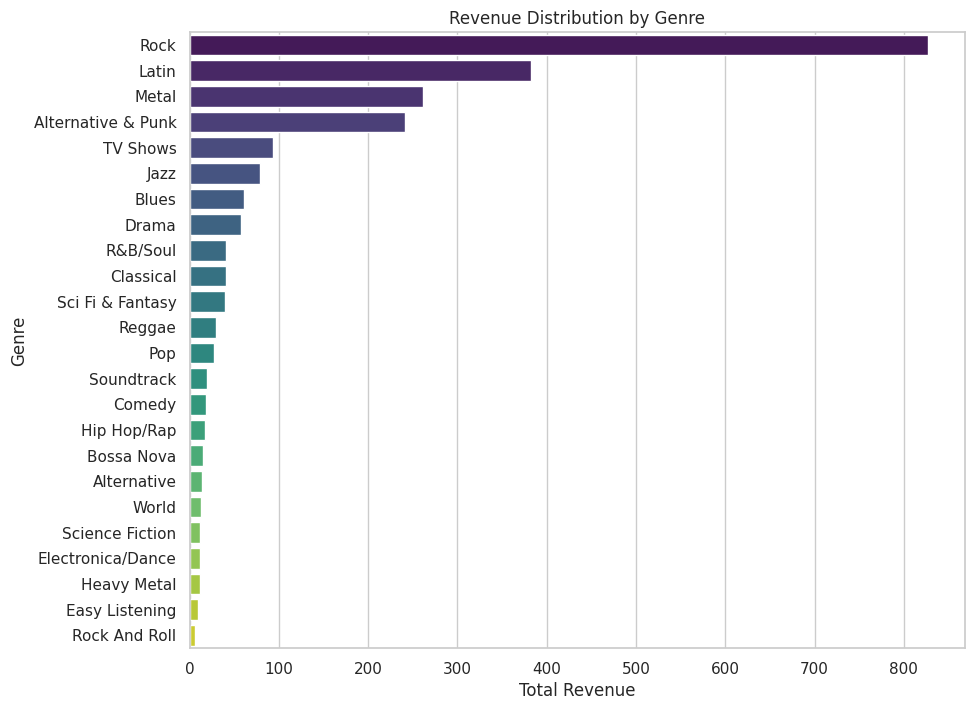

In [11]:
query_genre_revenue = """
select g.Name as genre_name,SUM(il.UnitPrice * il.Quantity) AS TotalRevenue 
from invoiceline il
join track t on il.TrackId = t.TrackId
join genre g on t.GenreId = g.GenreId
group by g.Name
"""
genre_revenue_df = pd.read_sql(query_genre_revenue, engine)
genre_revenue_df = genre_revenue_df.sort_values(by='TotalRevenue', ascending=False)

plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
sns.barplot(x='TotalRevenue', y='genre_name', data=genre_revenue_df, palette='viridis', hue='genre_name', dodge=False, legend=False)
plt.title('Revenue Distribution by Genre')
plt.xlabel('Total Revenue')
plt.ylabel('Genre')
plt.show()

Revenue Distribution of top 50 albums

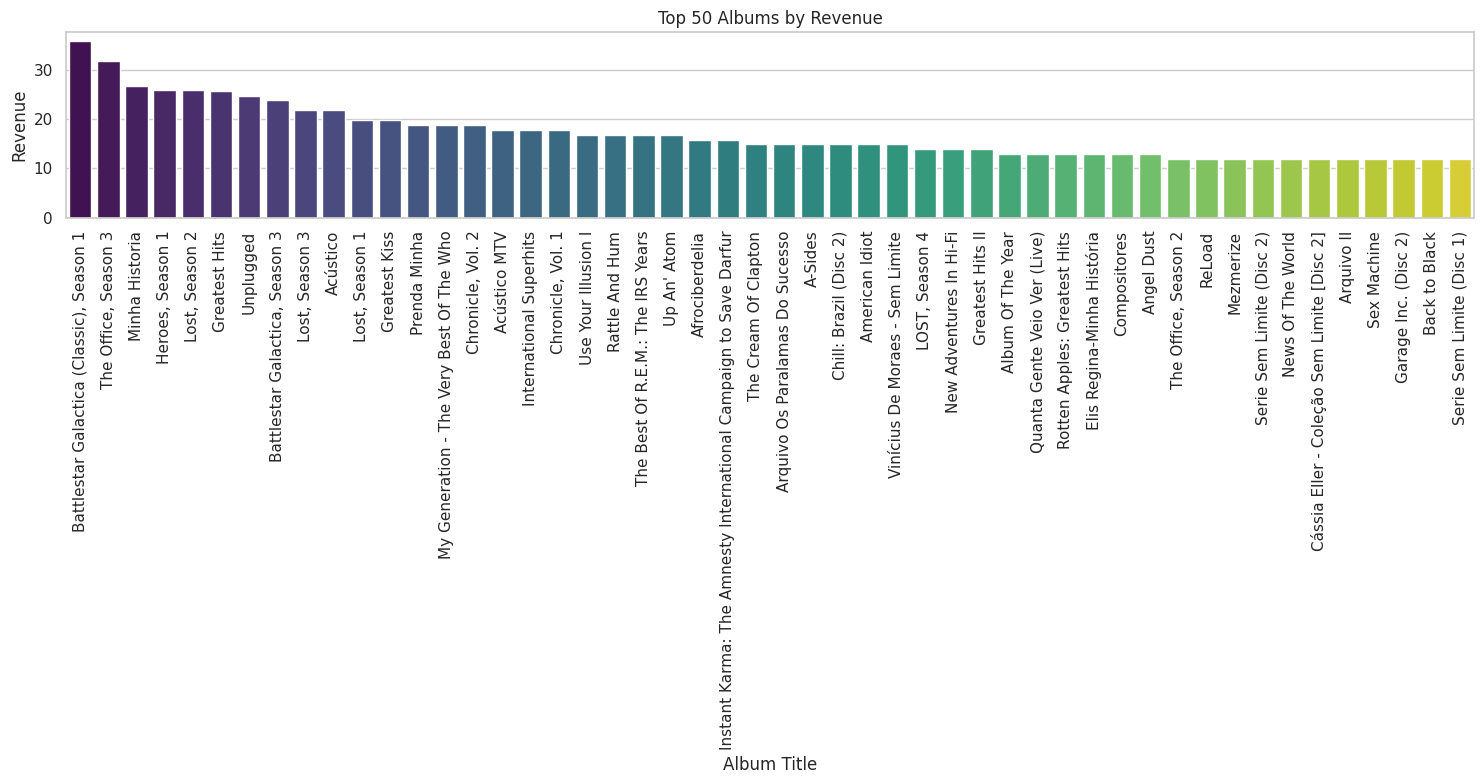

In [10]:
query_album_revenue = """
SELECT SUM(il.UnitPrice * il.Quantity) AS TotalRevenue, a.Title as AlbumTitle
FROM invoice i
JOIN invoiceline il ON i.InvoiceId = il.InvoiceId
JOIN track t ON il.TrackId = t.TrackId
JOIN album a ON t.AlbumId = a.AlbumId
GROUP BY a.Title, a.AlbumId
ORDER BY 1 DESC
LIMIT 50;
"""
album_revenue_df =pd.read_sql(query_album_revenue, engine)

sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))
sns.barplot(y='TotalRevenue', x='AlbumTitle', data=album_revenue_df, palette='viridis',legend=False,hue='AlbumTitle')
plt.title('Top 50 Albums by Revenue')
plt.xlabel('Album Title')
plt.ylabel('Revenue')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Revenue Distribution of Top 50 Tracks

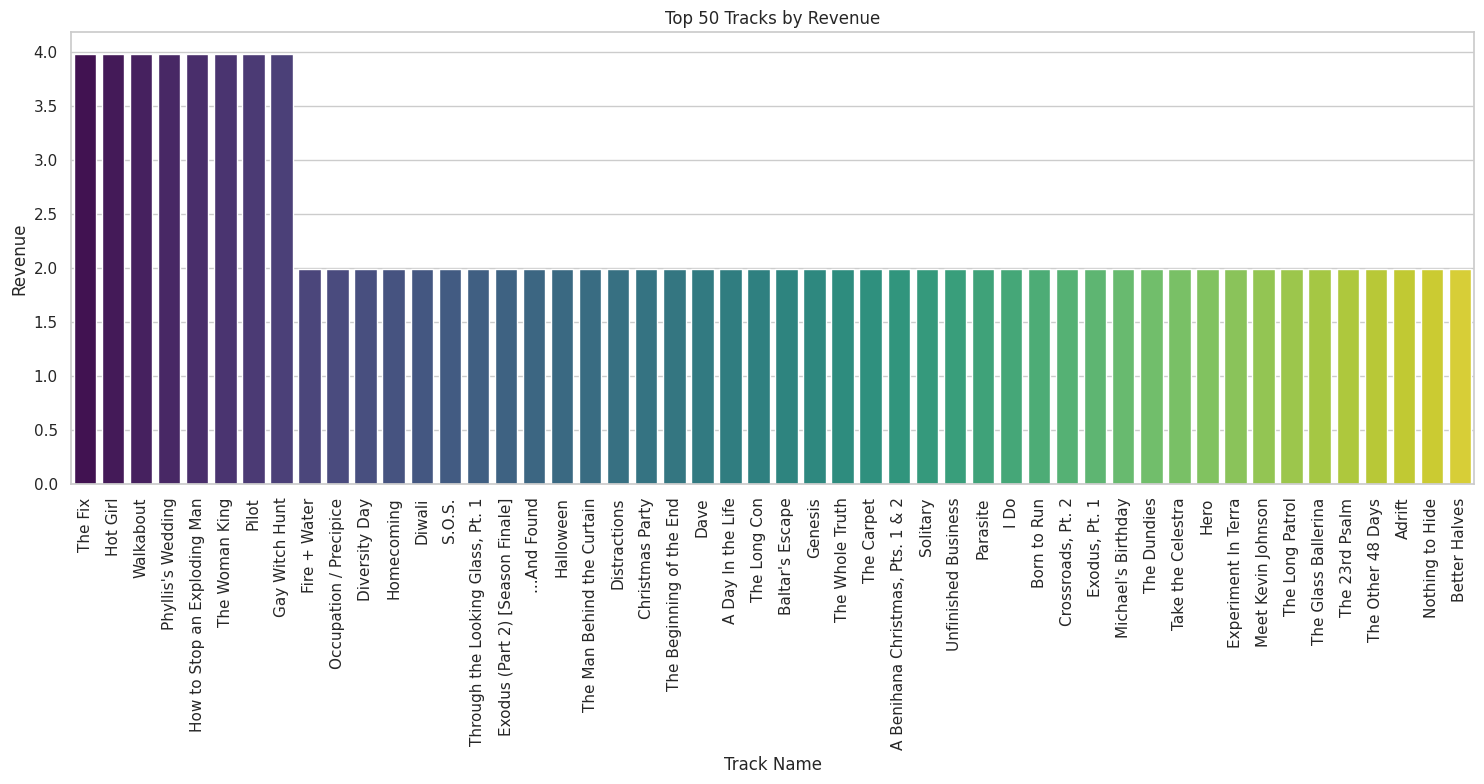

In [11]:
query_top_track="""
select il.TrackId,t.Name as TrackName,SUM(il.UnitPrice * il.Quantity) AS Revenue  from invoiceline il 
join track t on il.TrackId =t.TrackId 
group by il.TrackId ,t.Name 
order by Revenue desc
limit 50;
"""
top_track_df=pd.read_sql(query_top_track, engine)

sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))
sns.barplot(x='TrackName', y='Revenue', data=top_track_df, palette='viridis',legend=False,hue='TrackName')
plt.xticks(rotation=90)
plt.title('Top 50 Tracks by Revenue')
plt.xlabel('Track Name')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()

Revenue Distribution of top 20 Customer

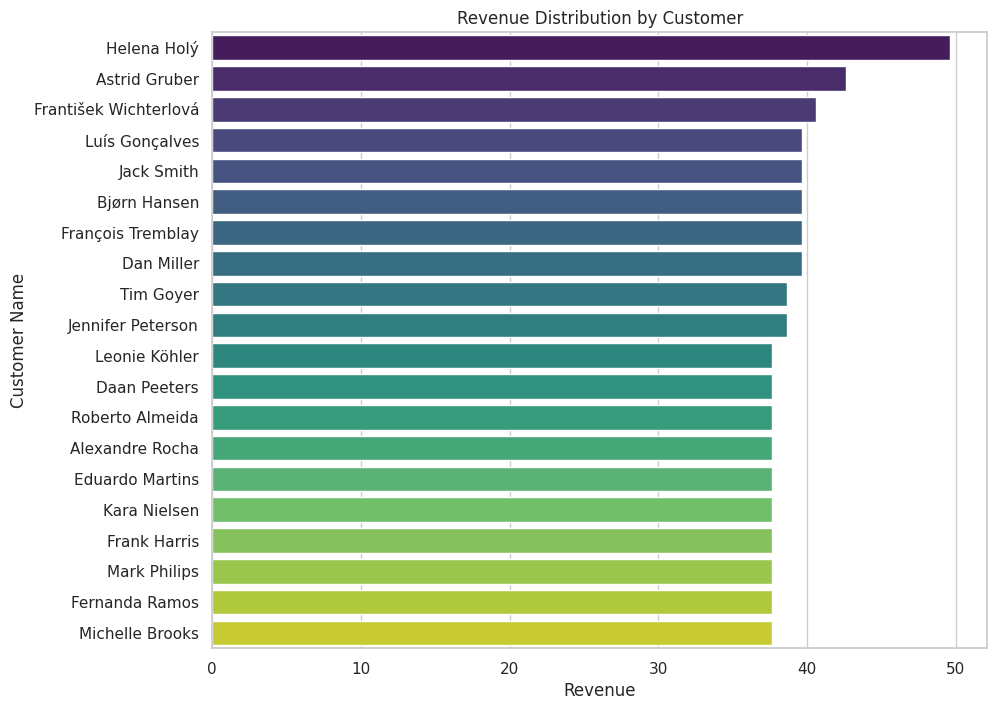

In [12]:
query = """
SELECT SUM(Total) as Revenue, i.CustomerId, CONCAT(FirstName, ' ', LastName) as CustomerName
FROM invoice i
JOIN customer c ON i.CustomerId = c.CustomerId
GROUP BY i.CustomerId, CONCAT(FirstName, ' ', LastName)
limit 20;
"""
customer_revenue_df = pd.read_sql(query, engine)

sns.set(style="whitegrid")
customer_revenue_df = customer_revenue_df.sort_values(by='Revenue', ascending=False)

plt.figure(figsize=(10, 8))
barplot = sns.barplot(x='Revenue', y='CustomerName', data=customer_revenue_df, palette='viridis',legend=False,hue='CustomerName')
plt.title('Revenue Distribution by Customer')
plt.xlabel('Revenue')
plt.ylabel('Customer Name')
plt.show()


# Artists

Artists with low track sales

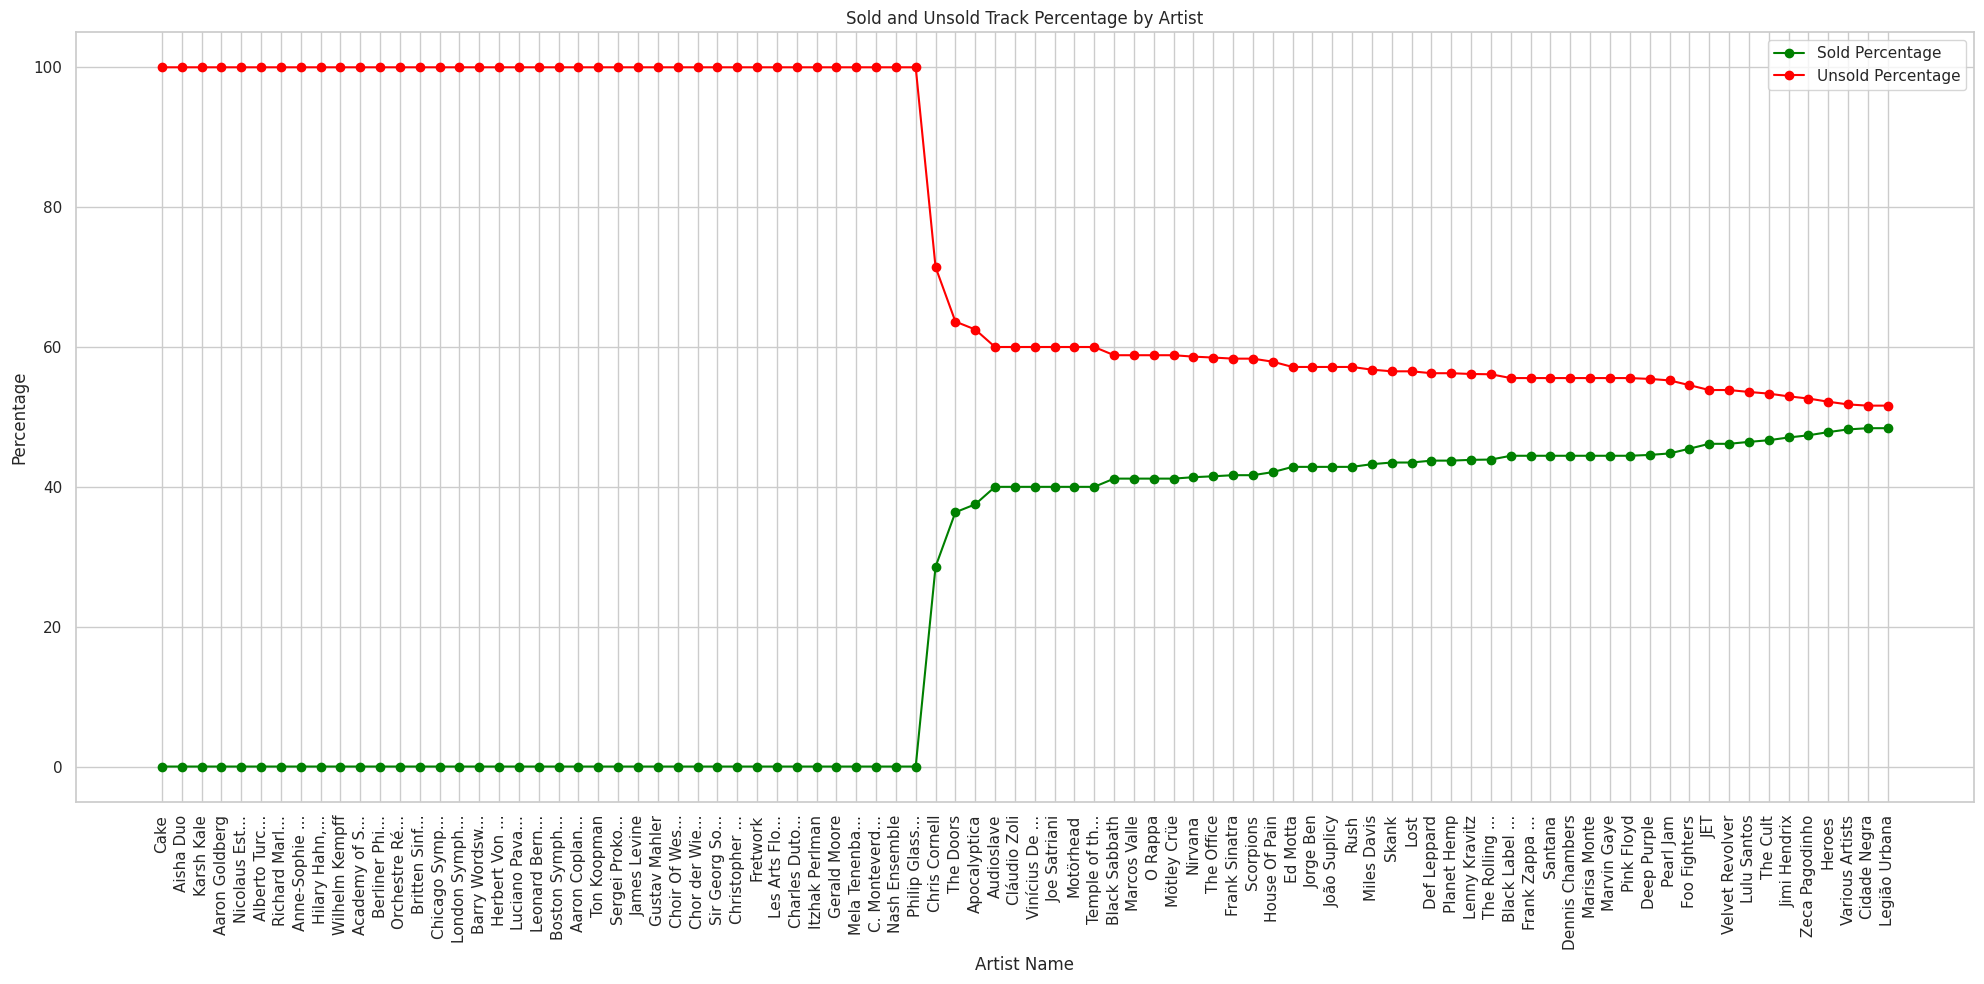

In [13]:
query= """
with AllTrackInfo as 
(
select Count(*) as AllTrack ,ar.Name as ArtistName 
from track t
join album a on t.AlbumId = a.AlbumId
join artist ar on a.ArtistId = ar.ArtistId
group by ar.Name
)
,soldTrackInfo as 
(
select Count(DISTINCT il.TrackId) soldCount,ar.Name as ArtistName 
from invoiceline il
join track t on il.TrackId=t.TrackId
join album a on t.AlbumId = a.AlbumId
join artist ar on a.ArtistId = ar.ArtistId
group by ar.Name
)
,result as 
(
select AllTrackInfo.ArtistName,AllTrack,ifnull(soldCount,0)/AllTrack*100 SoldPercentage
,(AllTrack - ifnull(soldCount,0))/AllTrack*100 as UnsoldPercentage 
from AllTrackInfo
left join soldTrackInfo on AllTrackInfo.ArtistName=soldTrackInfo.ArtistName
)
select ArtistName,SoldPercentage,unsoldPercentage,AllTrack from result
order by 3 desc;
"""
artist_data_df = pd.read_sql(query, engine)
artist_Performance_df=artist_data_df[(artist_data_df['UnsoldPercentage']>artist_data_df['SoldPercentage'])]
artist_Performance_df.loc[:, 'ArtistName'] = artist_Performance_df['ArtistName'].apply(lambda x: x if len(x) <= 15 else x[:12] + '...')


plt.figure(figsize=(20, 10))
plt.plot(artist_Performance_df['ArtistName'], artist_Performance_df['SoldPercentage'], marker='o', label='Sold Percentage', color='green')
plt.plot(artist_Performance_df['ArtistName'], artist_Performance_df['UnsoldPercentage'], marker='o', label='Unsold Percentage', color='red')
plt.title('Sold and Unsold Track Percentage by Artist')
plt.xlabel('Artist Name')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

Artists with over 80% track sales

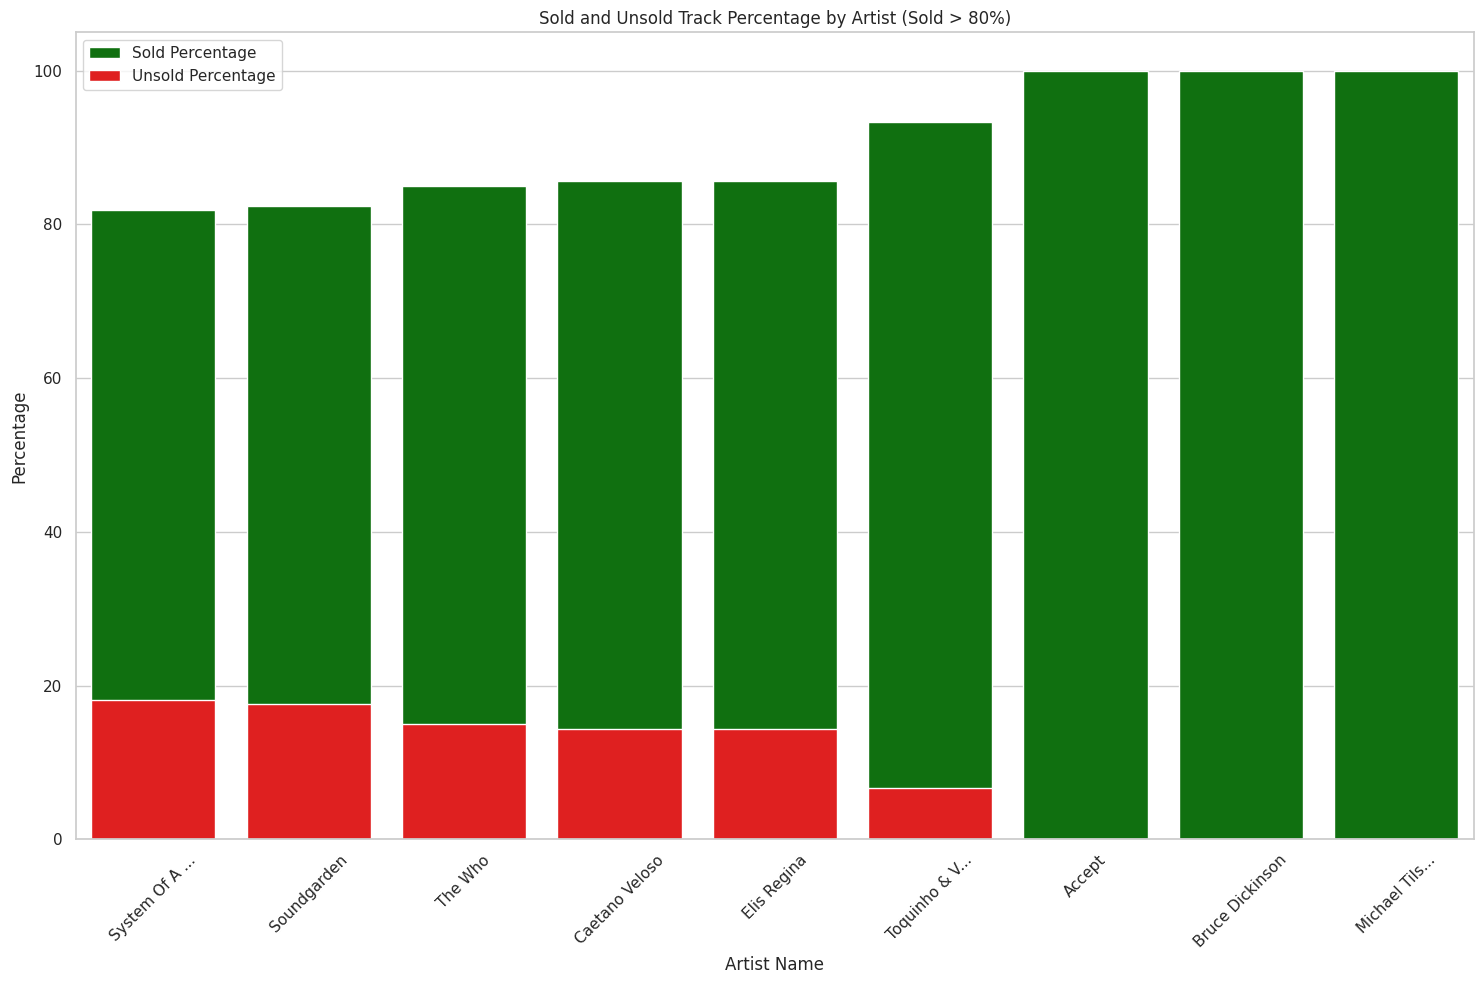

In [14]:
artist_over_80p_sold_data_df = artist_data_df[(artist_data_df['SoldPercentage'] > 80) & (artist_data_df['AllTrack'] !=1)]
# & (artist_data_df['AllTrack'] !=1)
artist_over_80p_sold_data_df.loc[:, 'ArtistName'] = artist_over_80p_sold_data_df['ArtistName'].apply(lambda x: x if len(x) <= 15 else x[:12] + '...')

sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.barplot(x='ArtistName', y='SoldPercentage', data=artist_over_80p_sold_data_df, color='green', label='Sold Percentage')
sns.barplot(x='ArtistName', y='UnsoldPercentage', data=artist_over_80p_sold_data_df, color='red', label='Unsold Percentage')
plt.title('Sold and Unsold Track Percentage by Artist (Sold > 80%)')
plt.xlabel('Artist Name')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Customer

Distribution of Customers by Country

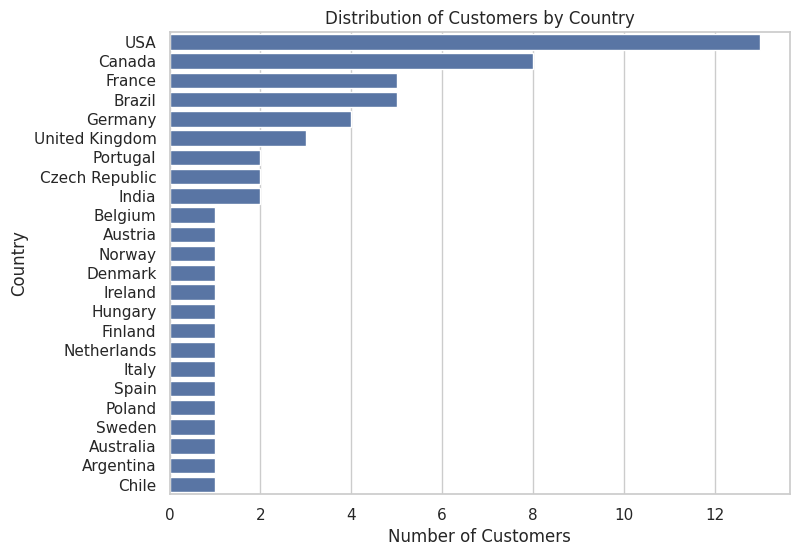

In [15]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(y=customer['Country'], order=customer['Country'].value_counts().index)
plt.title('Distribution of Customers by Country')
plt.xlabel('Number of Customers')
plt.ylabel('Country')
plt.show()

# Employee

Total Track Sales by Employees Over the Years

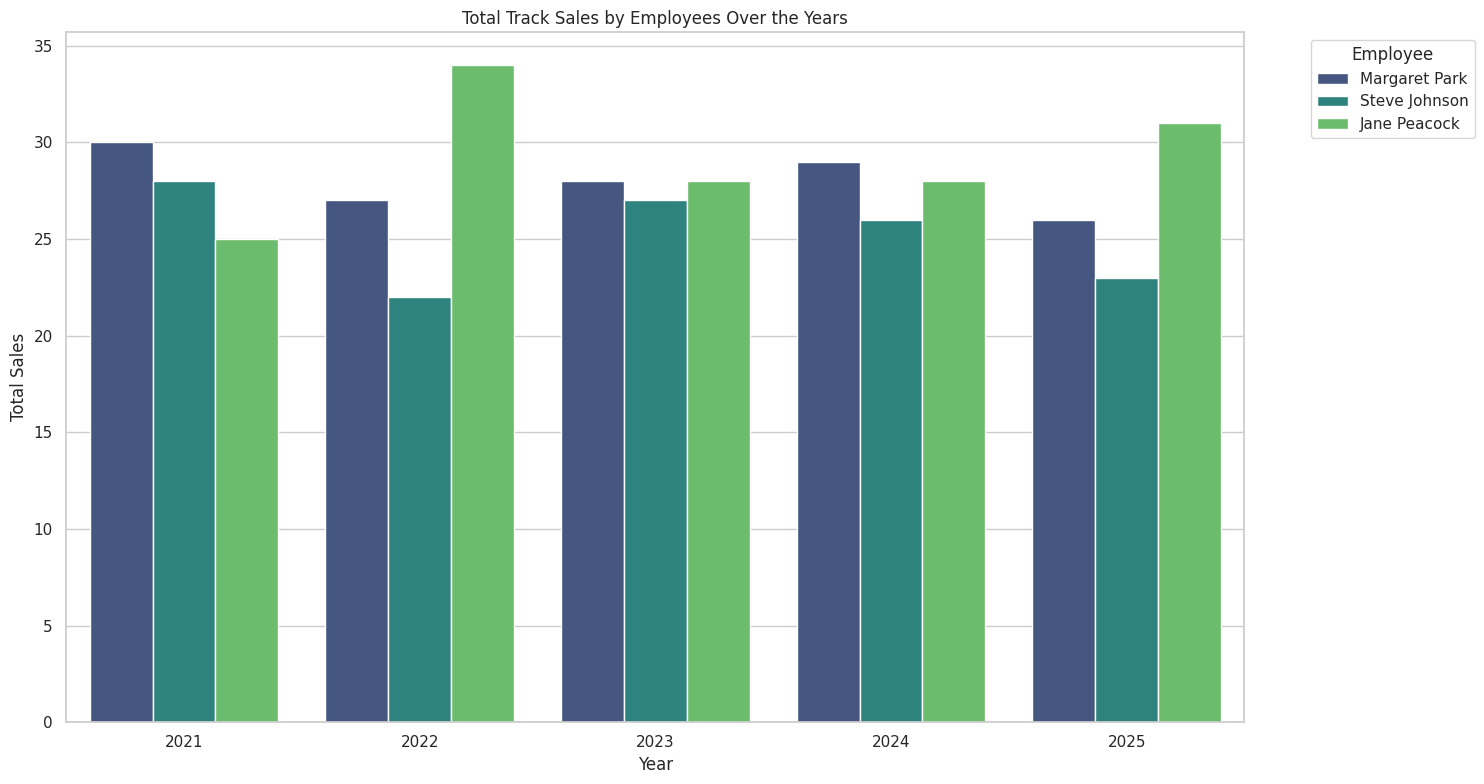

In [16]:
query_employee_sales = """
SELECT e.EmployeeId, CONCAT(e.FirstName, ' ', e.LastName) AS Fullname, COUNT(*) AS TotalSales, YEAR(InvoiceDate) AS Year
FROM invoice i
JOIN customer c ON i.CustomerId = c.CustomerId
JOIN employee e ON c.SupportRepId = e.EmployeeId
GROUP BY e.EmployeeId, Fullname, YEAR(InvoiceDate)
ORDER BY TotalSales DESC;
"""
employee_sales_df = pd.read_sql(query_employee_sales, engine)

sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))
sns.barplot(x='Year', y='TotalSales', hue='Fullname', data=employee_sales_df, palette='viridis')
plt.title('Total Track Sales by Employees Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='Employee', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Question 5.

Check Normality of data using Plots and Statistical test 

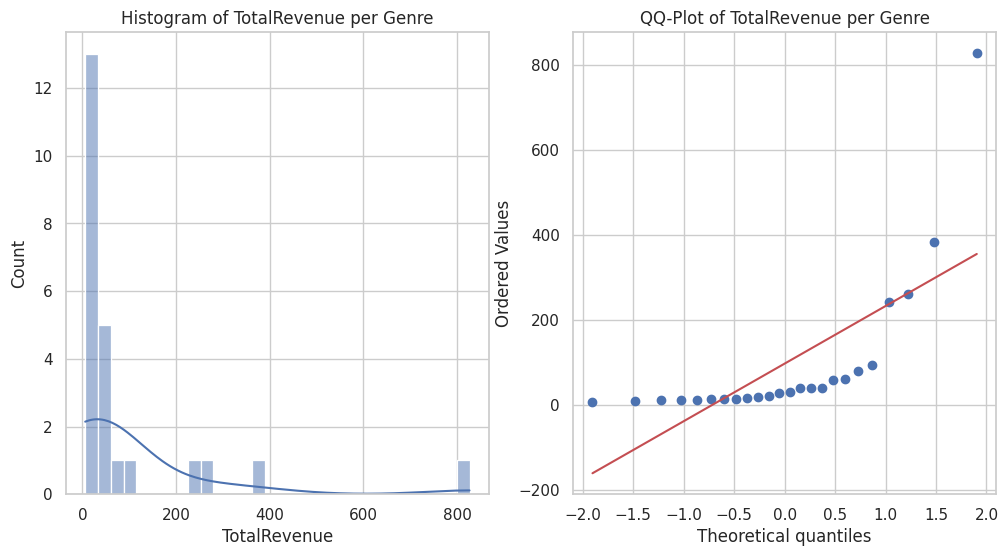

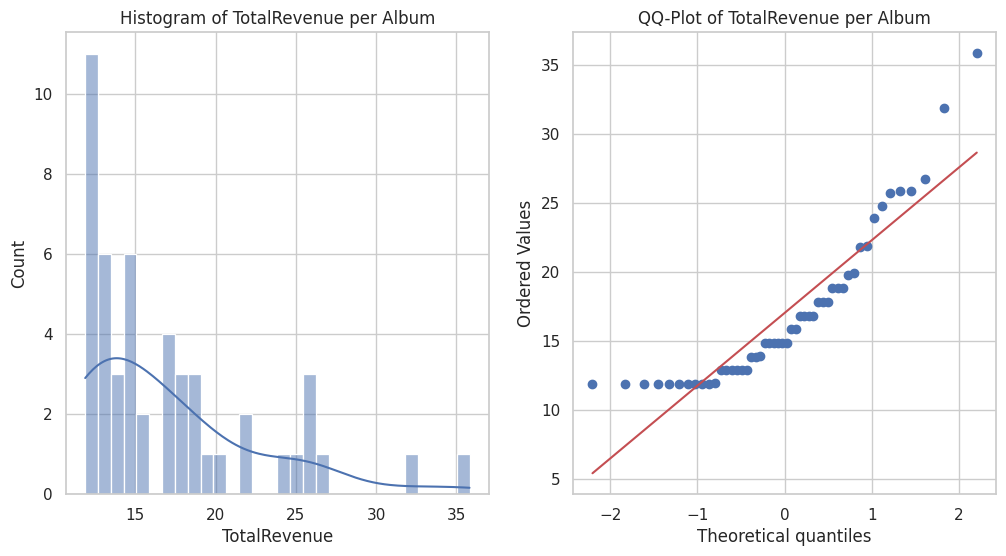

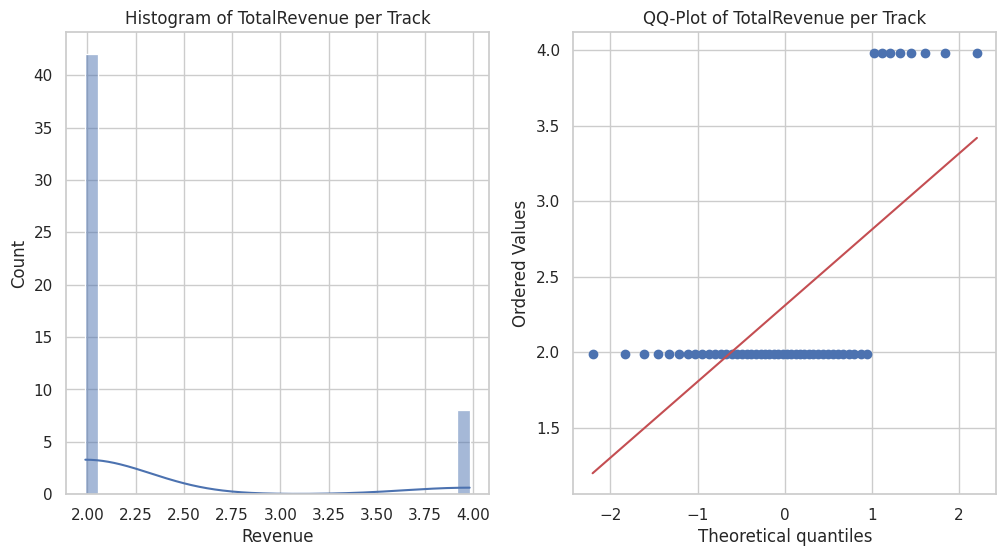

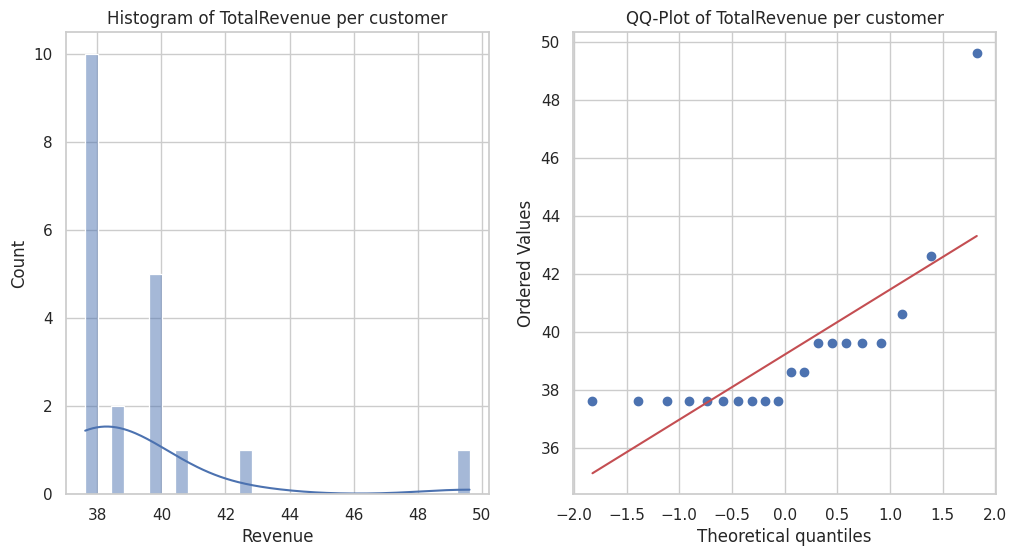

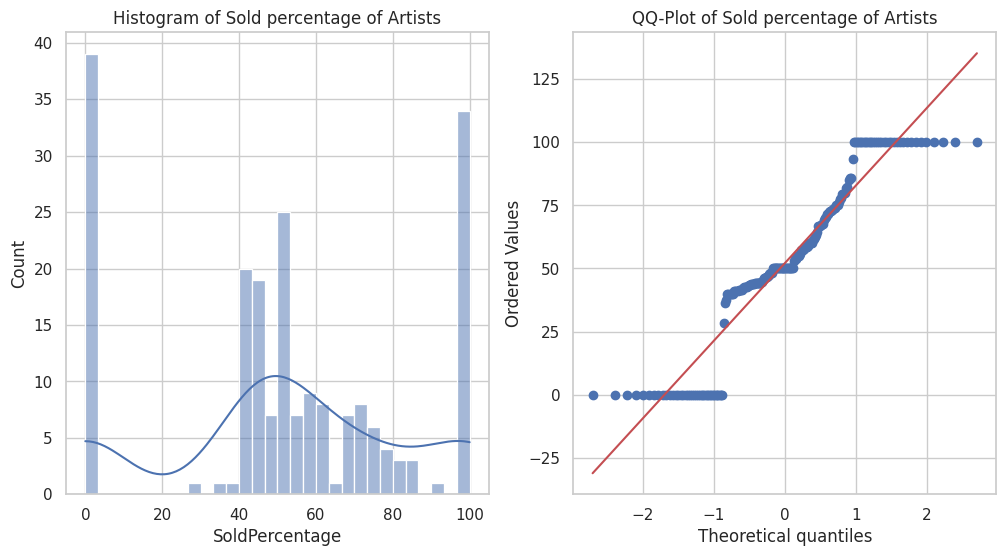

Statistical Tests for TotalRevenue per Genre:
Shapiro-Wilk Test: 
Statistics=0.5303114220012801, p-value=1.1253966042720898e-07
Reject the null hypothesis: The data does not appear to be normally distributed.

Kolmogorov-Smirnov Test:
Statistics=0.3409993193171929, p-value=0.005398620879835336
Reject the null hypothesis: The data does not appear to be normally distributed.

D'Agostino's K^2 Test:
Statistics=39.53796499619787, p-value=2.5968088838479216e-09
Reject the null hypothesis: The data does not appear to be normally distributed.

Statistical Tests for TotalRevenue per Album:
Shapiro-Wilk Test: 
Statistics=0.8393431450734239, p-value=8.060205902634084e-06
Reject the null hypothesis: The data does not appear to be normally distributed.

Kolmogorov-Smirnov Test:
Statistics=0.17876503771818997, p-value=0.07198393018409233
Fail to reject the null hypothesis: The data appears to be normally distributed.

D'Agostino's K^2 Test:
Statistics=17.794422505192106, p-value=0.00013676981159600

In [17]:
# Visual Method: Histograms and QQ-Plots
def plot_histogram_and_qqplot(data, title):
    plt.figure(figsize=(12, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data,bins=30, kde=True)
    plt.title(f'Histogram of {title}')

    # QQ-Plot
    plt.subplot(1, 2, 2)
    probplot(data, dist="norm", plot=plt)
    plt.title(f'QQ-Plot of {title}')
    plt.show()

# Statistical Tests
def perform_statistical_tests(data, variable_name):
    print(f"{GREEN}Statistical Tests for {variable_name}:{RESET}")

    # Shapiro-Wilk Test
    shapiro_stat, shapiro_p = shapiro(data)
    print(f"Shapiro-Wilk Test: \nStatistics={shapiro_stat}, p-value={shapiro_p}")
    alpha = 0.05
    if shapiro_p < alpha:
        print('Reject the null hypothesis: The data does not appear to be normally distributed.\n')
    else:
        print('Fail to reject the null hypothesis: The data appears to be normally distributed.\n')

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p = kstest(data, 'norm', args=(data.mean(), data.std()))
    print(f"Kolmogorov-Smirnov Test:\nStatistics={ks_stat}, p-value={ks_p}")
    if ks_p < alpha:
        print('Reject the null hypothesis: The data does not appear to be normally distributed.\n')
    else:
        print('Fail to reject the null hypothesis: The data appears to be normally distributed.\n')

    # D'Agostino's K^2 Test
    dagostino_stat, dagostino_p = normaltest(data)
    print(f"D'Agostino's K^2 Test:\nStatistics={dagostino_stat}, p-value={dagostino_p}")
    if dagostino_p < alpha:
        print('Reject the null hypothesis: The data does not appear to be normally distributed.\n')
    else:
        print('Fail to reject the null hypothesis: The data appears to be normally distributed.\n')



# Plot histograms and QQ-Plots for TotalRevenue and Track Duration
plot_histogram_and_qqplot(genre_revenue_df['TotalRevenue'], 'TotalRevenue per Genre')
plot_histogram_and_qqplot(album_revenue_df['TotalRevenue'],'TotalRevenue per Album')
plot_histogram_and_qqplot(top_track_df['Revenue'],'TotalRevenue per Track')
plot_histogram_and_qqplot(customer_revenue_df['Revenue'], 'TotalRevenue per customer')
plot_histogram_and_qqplot(artist_data_df['SoldPercentage'],'Sold percentage of Artists')


# Perform statistical tests for Total and Seconds
perform_statistical_tests(genre_revenue_df['TotalRevenue'], 'TotalRevenue per Genre')
perform_statistical_tests(album_revenue_df['TotalRevenue'],'TotalRevenue per Album')
perform_statistical_tests(top_track_df['Revenue'],'TotalRevenue per Track')
perform_statistical_tests(customer_revenue_df['Revenue'], 'TotalRevenue per customer')
perform_statistical_tests(artist_data_df['SoldPercentage'],'Sold percentage of Artists')


# Question 6.

Outliers by Z_Score method
genre revenue Outliers:
0    826.65
Name: TotalRevenue, dtype: float64

album revenue Outliers:
0    35.82
1    31.84
Name: TotalRevenue, dtype: float64

top track revenue Outliers:
0    3.98
1    3.98
2    3.98
3    3.98
4    3.98
5    3.98
6    3.98
7    3.98
Name: Revenue, dtype: float64

customer revenue Outliers:
5    49.62
Name: Revenue, dtype: float64

artist revenue Outliers:
Series([], Name: SoldPercentage, dtype: float64)

Outliers by IQR method
genre revenue Outliers:
0    826.65
6    382.14
2    261.36
3    241.56
Name: TotalRevenue, dtype: float64

album revenue Outliers:
0    35.82
1    31.84
Name: TotalRevenue, dtype: float64

top track revenue Outliers:
0    3.98
1    3.98
2    3.98
3    3.98
4    3.98
5    3.98
6    3.98
7    3.98
Name: Revenue, dtype: float64

customer revenue Outliers:
5    49.62
Name: Revenue, dtype: float64

artist revenue Outliers:
Series([], Name: SoldPercentage, dtype: float64)



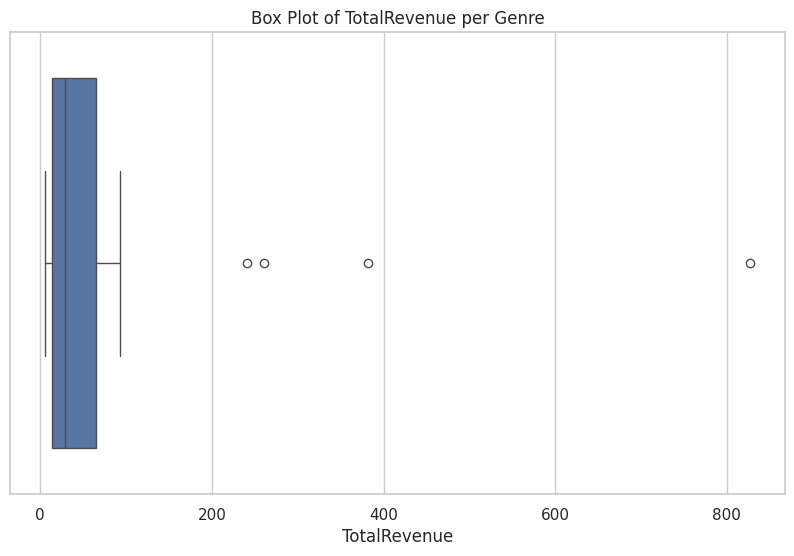

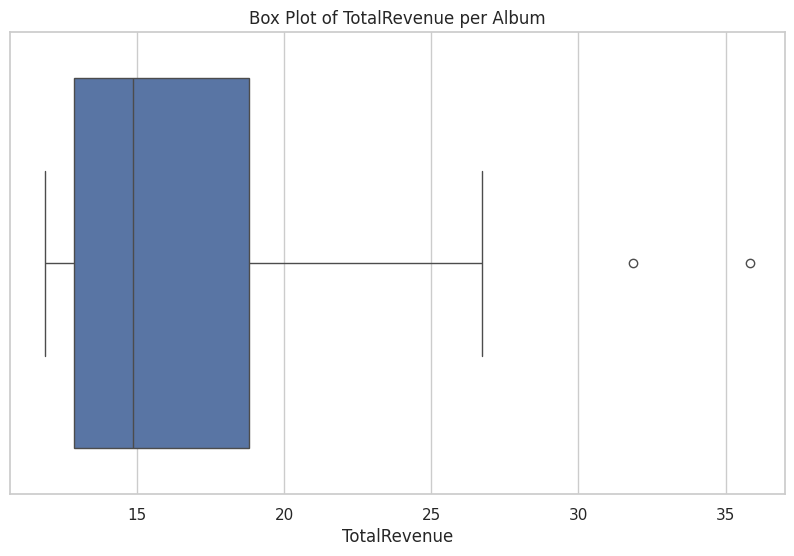

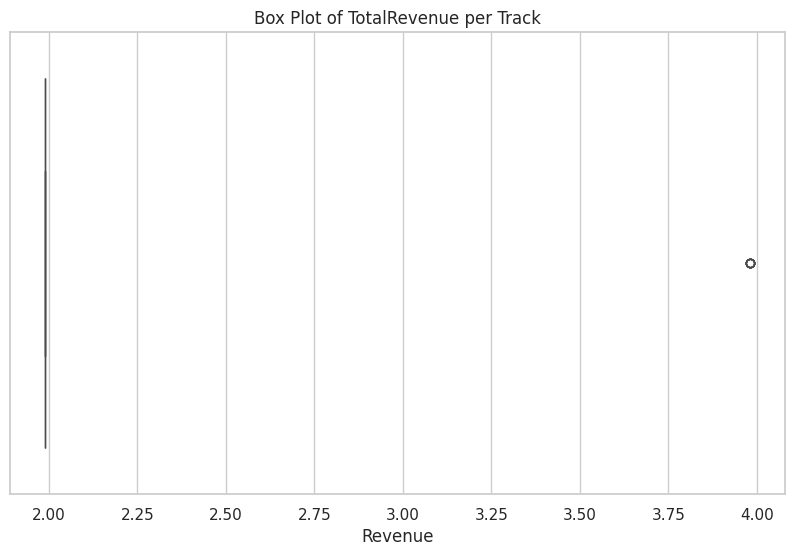

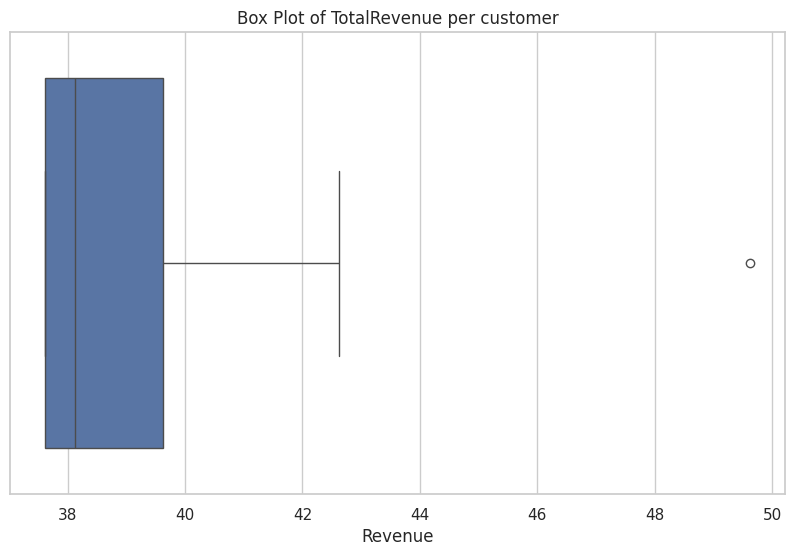

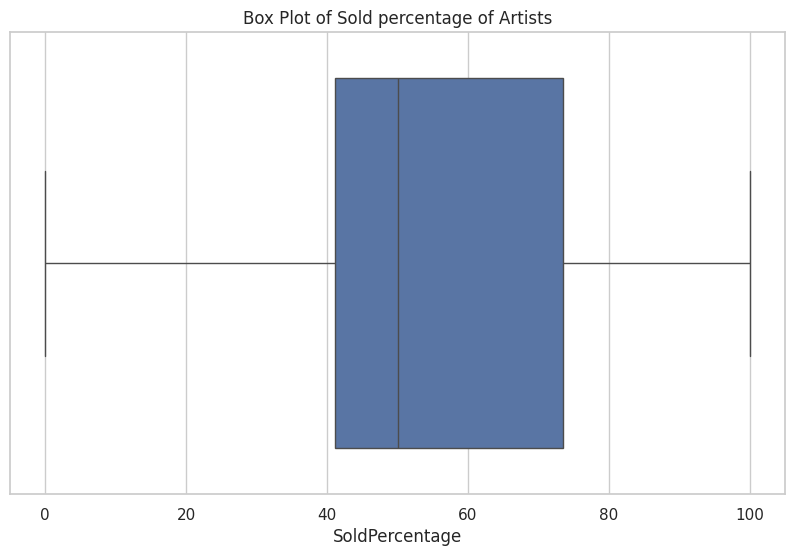

In [18]:
# detect_outliers based on Z-score method
def detect_outliers_zscore(data, threshold=2):
    z_scores = zscore(data)
    outliers = np.abs(z_scores) > threshold
    return data[outliers]


# detect_outliers based on IQR method 
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers


# boxplot
def plot_boxplot(data, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data)
    plt.title(f'Box Plot of {title}')
    plt.show()


print(f"{GREEN}Outliers by Z_Score method{RESET}")
genre_revenue_outliers_z = detect_outliers_zscore(genre_revenue_df['TotalRevenue'])
album_revenue_outliers_z = detect_outliers_zscore(album_revenue_df['TotalRevenue'])
top_track_outliers_z = detect_outliers_zscore(top_track_df['Revenue'])
customer_revenue_outliers_z=detect_outliers_zscore(customer_revenue_df['Revenue'])
artist_data_outliers_z=detect_outliers_zscore(artist_data_df['SoldPercentage'])

print(f"genre revenue Outliers:\n{genre_revenue_outliers_z}\n")
print(f"album revenue Outliers:\n{album_revenue_outliers_z}\n")
print(f"top track revenue Outliers:\n{top_track_outliers_z}\n")
print(f"customer revenue Outliers:\n{customer_revenue_outliers_z}\n")
print(f"artist revenue Outliers:\n{artist_data_outliers_z}\n")

print(f"{GREEN}Outliers by IQR method{RESET}")
genre_revenue_outliers = detect_outliers_iqr(genre_revenue_df['TotalRevenue'])
album_revenue_outliers = detect_outliers_iqr(album_revenue_df['TotalRevenue'])
top_track_outliers= detect_outliers_iqr(top_track_df['Revenue'])
customer_revenue_outliers=detect_outliers_iqr(customer_revenue_df['Revenue'])
artist_data_outliers=detect_outliers_iqr(artist_data_df['SoldPercentage'])

print(f"genre revenue Outliers:\n{genre_revenue_outliers}\n")
print(f"album revenue Outliers:\n{album_revenue_outliers}\n")
print(f"top track revenue Outliers:\n{top_track_outliers}\n")
print(f"customer revenue Outliers:\n{customer_revenue_outliers}\n")
print(f"artist revenue Outliers:\n{artist_data_outliers}\n")

plot_boxplot(genre_revenue_df['TotalRevenue'], 'TotalRevenue per Genre')
plot_boxplot(album_revenue_df['TotalRevenue'],'TotalRevenue per Album')
plot_boxplot(top_track_df['Revenue'],'TotalRevenue per Track')
plot_boxplot(customer_revenue_df['Revenue'], 'TotalRevenue per customer')
plot_boxplot(artist_data_df['SoldPercentage'],'Sold percentage of Artists')

# Question 7.

In [19]:
merged_df = pd.merge(invoiceline[['TrackId','UnitPrice','Quantity']], track[['TrackId','GenreId']], on='TrackId')
merged_df = pd.merge(merged_df, genre[['GenreId','Name']], on='GenreId')
merged_df['TotalRevenue'] = merged_df['UnitPrice'] * merged_df['Quantity']
grouped_data = merged_df.groupby('Name')['TotalRevenue'].sum().reset_index()
sorted_data = grouped_data.sort_values(by='TotalRevenue', ascending=False).head(3)
sorted_data

,Name,TotalRevenue
17,Rock,826.65
12,Latin,382.14
13,Metal,261.36


In [20]:
top_genres = sorted_data['Name'].tolist()
top_genre_data = merged_df[merged_df['Name'].isin(top_genres)]
# استخراج داده‌های مربوط به قیمت واحد برای هر ژانر
A = top_genre_data[top_genre_data['Name'] == top_genres[0]]['UnitPrice']
B = top_genre_data[top_genre_data['Name'] == top_genres[1]]['UnitPrice']
C = top_genre_data[top_genre_data['Name'] == top_genres[2]]['UnitPrice']

stat, p_value = kruskal(A, B, C)

print(f"Kruskal-Wallis Statistic: {stat}")
print(f"P-Value: {p_value}")

# تصمیم‌گیری بر اساس مقدار p
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in mean unit price among the top genres.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in mean unit price among the top genres.")

ValueError: All numbers are identical in kruskal

Correlation Between Track Length and Unit Price

In [21]:
corr, p_value = pearsonr(track['Milliseconds']/60000, track['UnitPrice'])

print(f"Pearson Correlation Coefficient: {corr}")
print(f"P-Value: {p_value}")

# تصمیم‌گیری بر اساس مقدار p
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant correlation between track length and unit price.")
else:
    print("Fail to reject the null hypothesis: There is no significant correlation between track length and unit price.")

Pearson Correlation Coefficient: 0.9317964749112742
P-Value: 0.0
Reject the null hypothesis: There is a significant correlation between track length and unit price.


Association Between Genre and Media Type

In [22]:
merged_Track_genre_df = pd.merge(genre[['GenreId','Name']], track[['TrackId','GenreId','MediaTypeId']], on='GenreId')
merged_Track_genre_MediaType_df = pd.merge(merged_Track_genre_df, mediatype, on='MediaTypeId')

# Rename the columns
merged_Track_genre_MediaType_df = merged_Track_genre_MediaType_df.rename(columns={
    'Name_x': 'GenreName',
    'Name_y': 'MediaTypeName'
})

contingency_table = pd.crosstab(merged_Track_genre_MediaType_df['GenreName'], merged_Track_genre_MediaType_df['MediaTypeName'])


chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: There is a significant association between genre and media type.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between genre and media type.")

Chi-Square Statistic: 5650.180437321978
P-Value: 0.0
Reject the null hypothesis: There is a significant association between genre and media type.


# Extra Question

Relationship between Track Count and Genre

Chi-Square Statistic: 1261.9262068327364
P-Value: 1.7480653059388465e-45
Reject the null hypothesis: There is a significant relationship between Track Count and Genre.


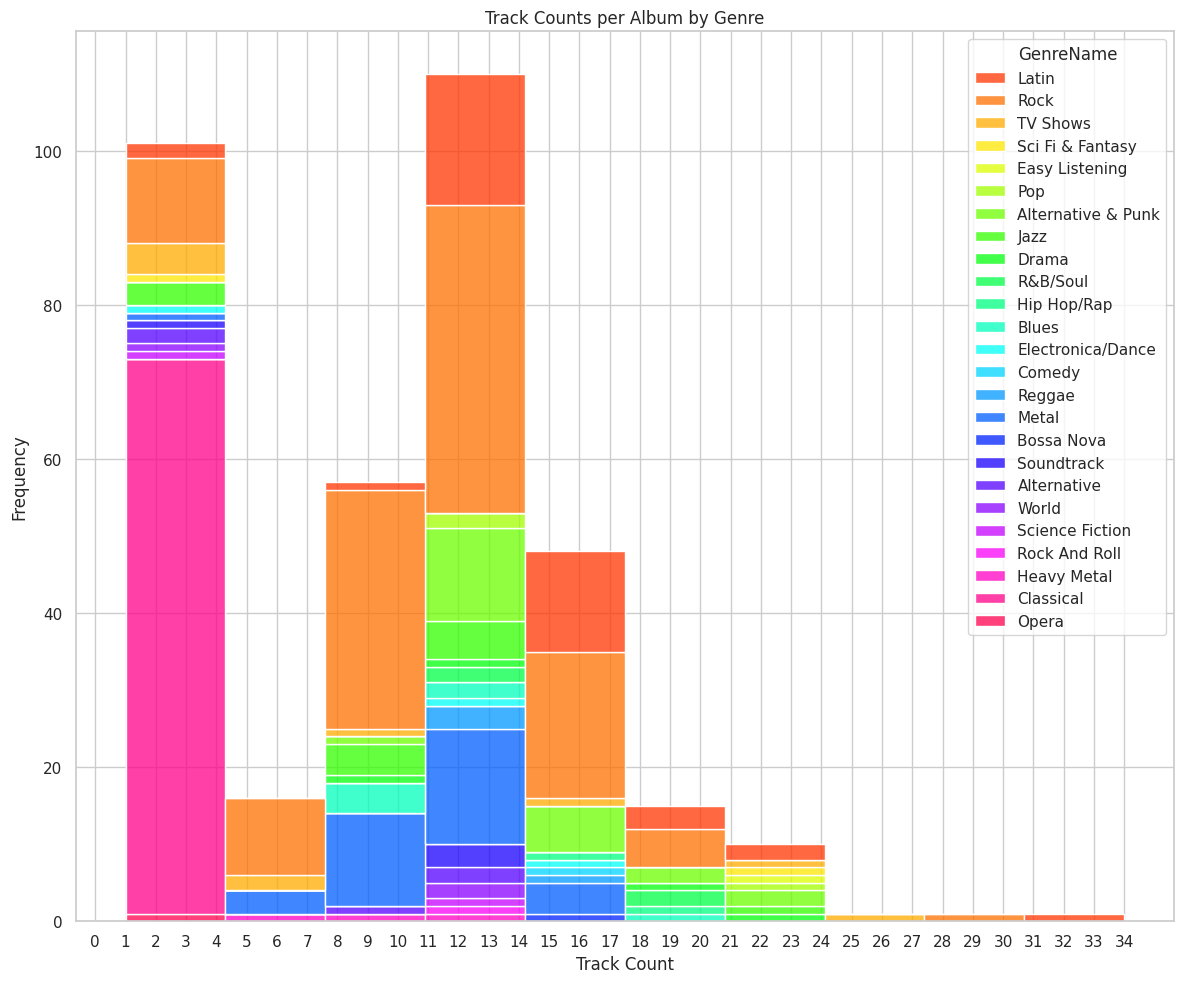

In [23]:
track_counts_per_album_by_genre_df = (
    track
    .merge(genre, on='GenreId')
    .groupby(['AlbumId', 'Name_y'])
    .size()
    .reset_index(name='TrackCount')
    .rename(columns={'Name_y': 'GenreName'})
    .sort_values(by='TrackCount', ascending=False)
)

contingency_table = pd.crosstab(track_counts_per_album_by_genre_df['TrackCount'], track_counts_per_album_by_genre_df['GenreName'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-Square Statistic: {chi2}')
print(f'P-Value: {p}')
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: There is a significant relationship between Track Count and Genre.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between Track Count and Genre.")

custom_palette = sns.color_palette("hsv", 25)
plt.figure(figsize=(12, 10))
sns.histplot(track_counts_per_album_by_genre_df, x='TrackCount', hue='GenreName', multiple='stack', palette=custom_palette)
plt.title('Track Counts per Album by Genre')
plt.xlabel('Track Count')
plt.ylabel('Frequency')
max_track_count = track_counts_per_album_by_genre_df['TrackCount'].max()
plt.xticks(np.arange(0, max_track_count + 1, step=1))
plt.tight_layout()
plt.show()    

Correlation Between Track Count and Revenue

Correlation between Track Count and Revenue: 0.82


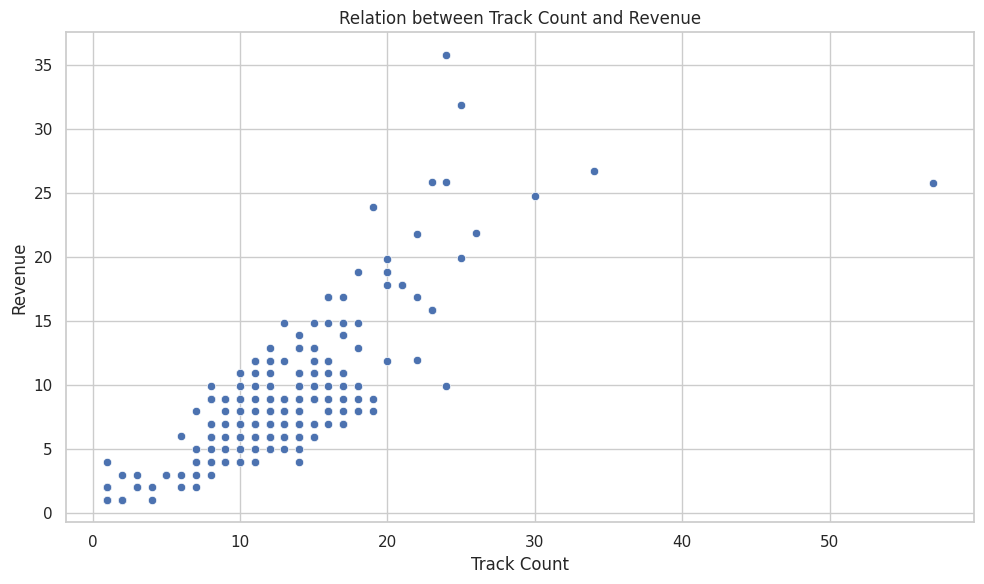

In [24]:
track_count_per_album = (
    track.groupby('AlbumId')
    .size()
    .reset_index(name='TrackCount')
)

album_revenue_by_trackCount_df = (
    invoice
    .merge(invoiceline,left_on='InvoiceId',right_on='InvoiceId')
    .merge(track, left_on='TrackId', right_on='TrackId')
    .merge(album, left_on='AlbumId', right_on='AlbumId')
)
album_revenue_by_trackCount_df['Revenue'] = album_revenue_by_trackCount_df['UnitPrice_x'] * album_revenue_by_trackCount_df['Quantity']
album_revenue_by_trackCount_df=album_revenue_by_trackCount_df[['Quantity','UnitPrice_x','AlbumId','Title','Revenue']].groupby(['AlbumId', 'Title']).agg({'Revenue': 'sum'}).reset_index()
album_revenue_by_trackCount_df=album_revenue_by_trackCount_df.merge(track_count_per_album, on='AlbumId')

# Correlation between Track Count and Revenue
correlation = album_revenue_by_trackCount_df['TrackCount'].corr(album_revenue_by_trackCount_df['Revenue'])
print(f'Correlation between Track Count and Revenue: {correlation:.2f}')
album_revenue_by_trackCount_df

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TrackCount', y='Revenue', data=album_revenue_by_trackCount_df)
plt.title('Relation between Track Count and Revenue')
plt.xlabel('Track Count')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()



Correlation between Employee Age and Total Sales

Correlation between Employee Age and Total Sales: -0.12


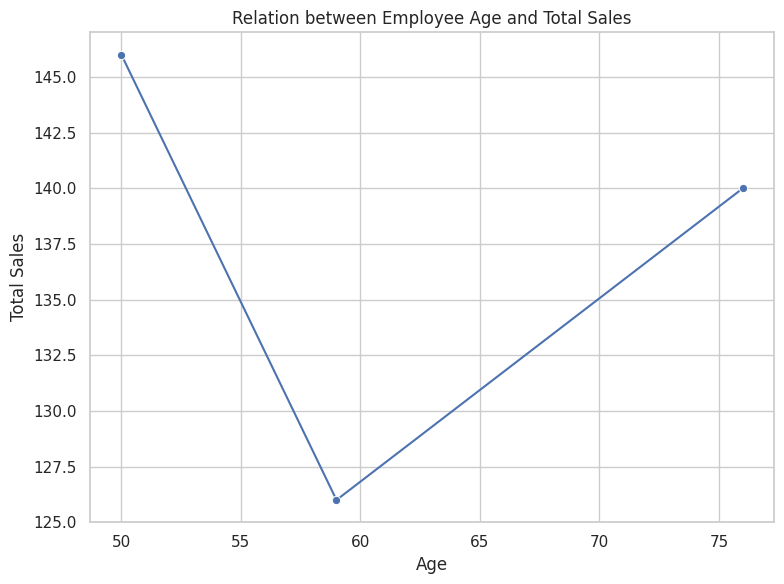

In [25]:
now = datetime.now()
employee['Age'] = employee['BirthDate'].apply(lambda x: now.year - x.year - ((now.month, now.day) < (x.month, x.day)))
employee_revenue_df = (
    invoice
    .merge(customer,left_on='CustomerId',right_on='CustomerId')
    .merge(employee, left_on='SupportRepId', right_on='EmployeeId')
    .groupby(['EmployeeId','Age'])
    .size()
    .reset_index(name='TotalSales')
)

# محاسبه ضریب همبستگی
correlation = employee_revenue_df['Age'].corr(employee_revenue_df['TotalSales'])
print(f'Correlation between Employee Age and Total Sales: {correlation:.2f}')

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.lineplot(x='Age', y='TotalSales', data=employee_revenue_df, marker='o')
plt.title('Relation between Employee Age and Total Sales')
plt.xlabel('Age')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

Correlation between Track Duration and Revenue of top tracks

Correlation between Track Duration and Revenue of top tracks: -0.35


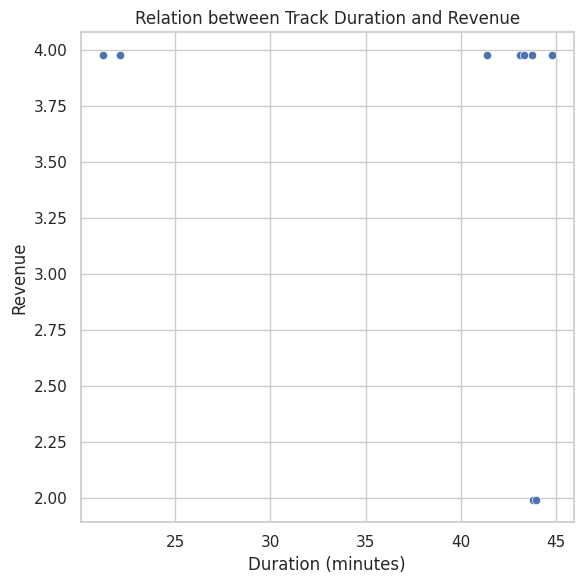

In [26]:
query_Duration_of_top_track="""
with cte as (
select il.TrackId,t.Name as TrackName,SUM(il.UnitPrice * il.Quantity) AS Revenue  from invoiceline il
join track t on il.TrackId =t.TrackId
group by il.TrackId ,t.Name
order by Revenue desc
limit 10)
select Revenue,Milliseconds/60000 Duration from cte
join track t on cte.TrackId=t.TrackId
"""
Duration_of_top_track_df=pd.read_sql(query_Duration_of_top_track, engine)

# محاسبه ضریب همبستگی
correlation = Duration_of_top_track_df['Duration'].corr(Duration_of_top_track_df['Revenue'])
print(f'Correlation between Track Duration and Revenue of top tracks: {correlation:.2f}')

plt.figure(figsize=(6, 6))
sns.scatterplot(x='Duration', y='Revenue', data=Duration_of_top_track_df)
plt.title('Relation between Track Duration and Revenue')
plt.xlabel('Duration (minutes)')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()

# Question 8.

Mean Track Duration: 11.12 minutes
95% Confidence Interval: (5.28, 16.97)


/tmp/ipykernel_821/1229296153.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90, horizontalalignment='right')


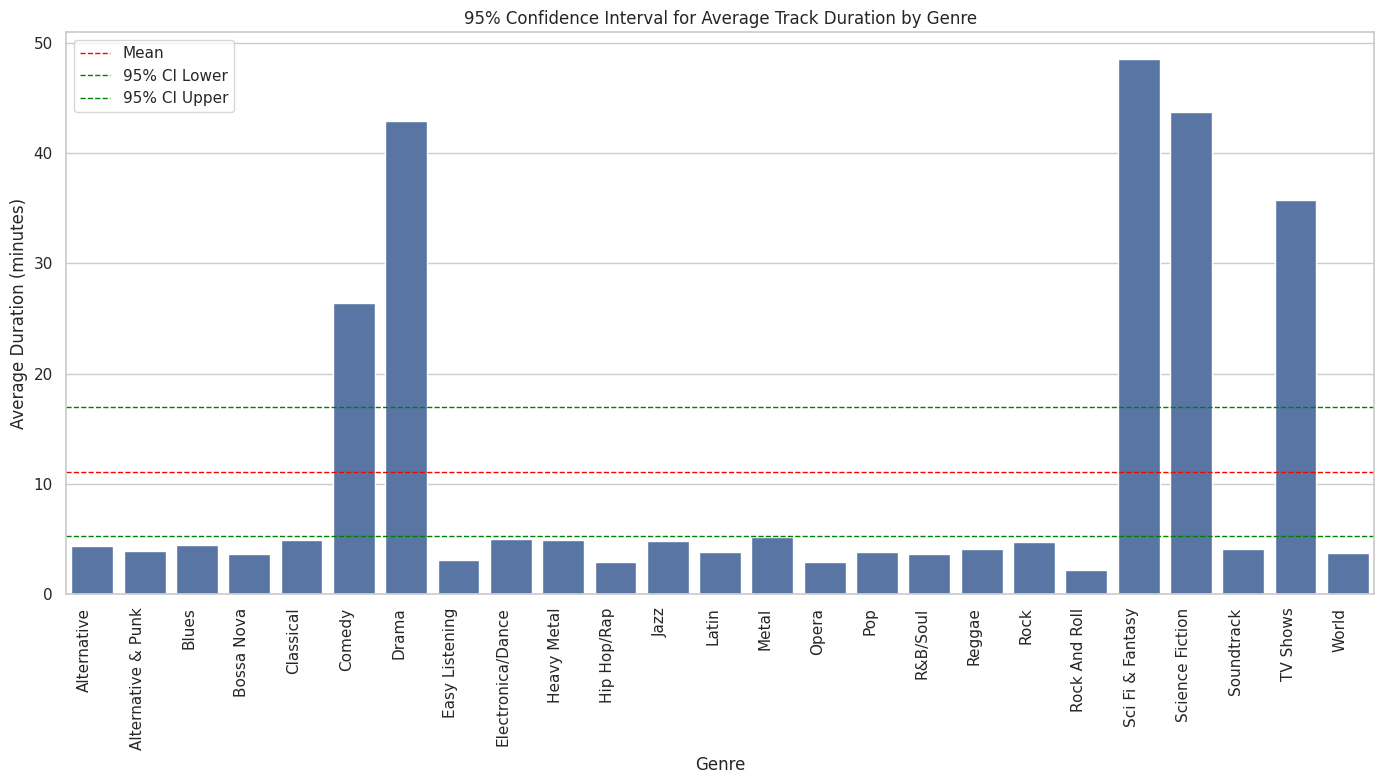

In [27]:
track_genre_df = track.merge(genre, on='GenreId')
track_genre_df['DurationMinutes'] = track_genre_df['Milliseconds'] / 60000

genre_duration_stats = (
    track_genre_df
    .groupby('Name_y')
    .agg(
        AvgDuration=('DurationMinutes', 'mean'),
        StdDev=('DurationMinutes', 'std'),
        Count=('DurationMinutes', 'count')
    )
    .reset_index()
    .rename(columns={'Name_y': 'GenreName'})
)

genre_duration_stats['StdError'] = genre_duration_stats['StdDev'] / np.sqrt(genre_duration_stats['Count'])
confidence_interval = 0.95
z_value = stats.norm.ppf(0.5 + confidence_interval / 2)

genre_duration_stats['CI Lower'] = genre_duration_stats['AvgDuration'] - z_value * genre_duration_stats['StdError']
genre_duration_stats['CI Upper'] = genre_duration_stats['AvgDuration'] + z_value * genre_duration_stats['StdError']

# محاسبه میانگین کلی و فاصله اطمینان کلی برای همه ژانرها
mean_duration = genre_duration_stats['AvgDuration'].mean()
std_dev_duration = genre_duration_stats['AvgDuration'].std()
count_duration = genre_duration_stats['AvgDuration'].count()

std_error = std_dev_duration / np.sqrt(count_duration)
ci_lower = mean_duration - z_value * std_error
ci_upper = mean_duration + z_value * std_error


print(f"Mean Track Duration: {mean_duration:.2f} minutes")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
bar_plot = sns.barplot(
    x='GenreName', 
    y='AvgDuration', 
    data=genre_duration_stats, 
    errorbar=None
)

plt.axhline(mean_duration, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axhline(ci_lower, color='green', linestyle='dashed', linewidth=1, label='95% CI Lower')
plt.axhline(ci_upper, color='green', linestyle='dashed', linewidth=1, label='95% CI Upper')

bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.title('95% Confidence Interval for Average Track Duration by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Duration (minutes)')
plt.legend()
plt.tight_layout()
plt.show()
# genre_duration_stats[['GenreName', 'AvgDuration', 'CI Lower', 'CI Upper']]

Mean Sales: 97.02
95% Confidence Interval: (51.66, 142.39)


/tmp/ipykernel_821/1780784937.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, horizontalalignment='right')


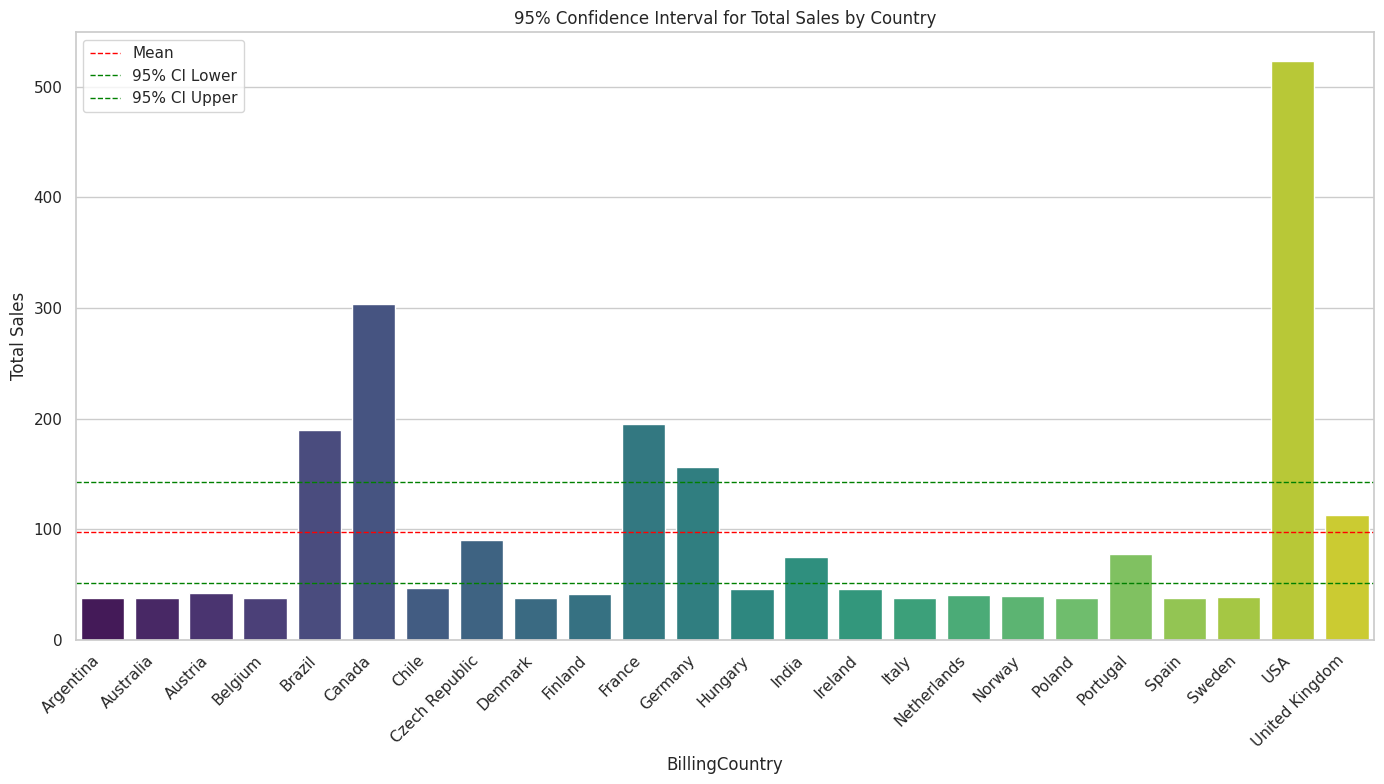

In [28]:
country_sales = (
    invoice
    .groupby('BillingCountry')
    .agg(TotalSales=('Total', 'sum'))
    .reset_index()
)

mean_sales = country_sales['TotalSales'].mean()
std_dev_sales = country_sales['TotalSales'].std()
count_sales = country_sales['TotalSales'].count()

std_error = std_dev_sales / np.sqrt(count_sales)
confidence_interval = 0.95
z_value = stats.norm.ppf(0.5 + confidence_interval / 2)

ci_lower = mean_sales - z_value * std_error
ci_upper = mean_sales + z_value * std_error

print(f"Mean Sales: {mean_sales:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
palette = sns.color_palette("viridis", len(country_sales))

bar_plot = sns.barplot(
    x='BillingCountry', 
    y='TotalSales', 
    data=country_sales, 
    palette=palette,
    errorbar=None,
    hue='BillingCountry'
)

# اضافه کردن خطوط فاصله اطمینان به نمودار
plt.axhline(mean_sales, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axhline(ci_lower, color='green', linestyle='dashed', linewidth=1, label='95% CI Lower')
plt.axhline(ci_upper, color='green', linestyle='dashed', linewidth=1, label='95% CI Upper')
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('95% Confidence Interval for Total Sales by Country')
plt.xlabel('BillingCountry')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

Mean Track Count: 37.97
95% Confidence Interval: (37.90, 38.03)


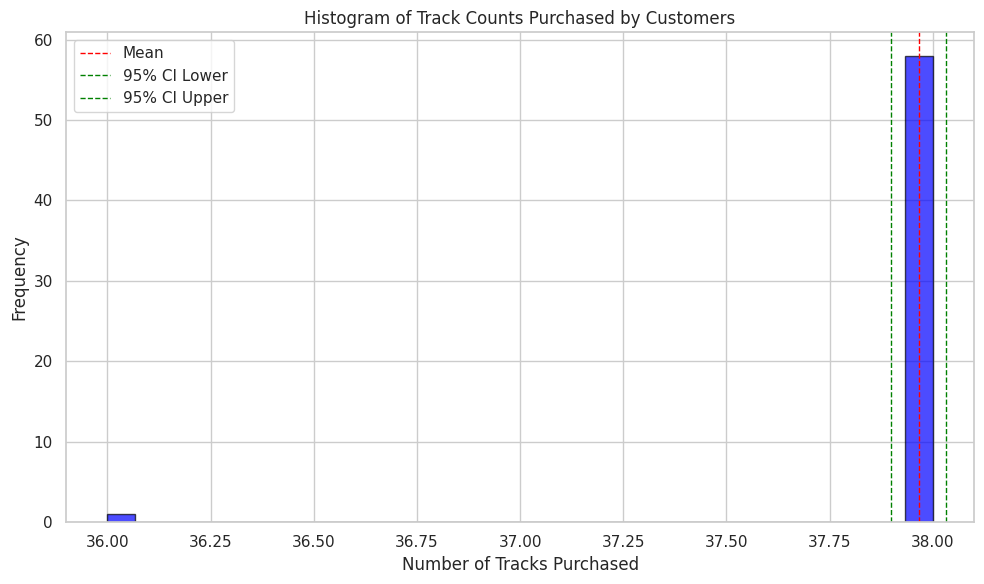

In [29]:
customer_track_counts = (
    invoice
    .merge(invoiceline,on='InvoiceId')
    .groupby('CustomerId')
    .agg(TrackCount=('InvoiceLineId', 'count'))
    .reset_index()
)
customer_track_counts


track_count_stats = customer_track_counts['TrackCount'].agg(['mean', 'count', 'std'])
track_count_stats
std_error = track_count_stats['std'] / np.sqrt(track_count_stats['count'])

confidence_interval = 0.95
z_value = stats.norm.ppf(0.5 + confidence_interval / 2)

ci_lower = track_count_stats['mean'] - z_value * std_error
ci_upper = track_count_stats['mean'] + z_value * std_error


print(f"Mean Track Count: {track_count_stats['mean']:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")
plt.figure(figsize=(10, 6))
plt.hist(customer_track_counts['TrackCount'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(track_count_stats['mean'], color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(ci_lower, color='green', linestyle='dashed', linewidth=1, label='95% CI Lower')
plt.axvline(ci_upper, color='green', linestyle='dashed', linewidth=1, label='95% CI Upper')
plt.title('Histogram of Track Counts Purchased by Customers')
plt.xlabel('Number of Tracks Purchased')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()